# Plotting the metric curves

This file contains functions for plotting the metric curves in the paper.

In [1]:
%matplotlib inline
import os
import errno
import warnings
import numpy as np
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [2]:
# Deal with the bold roman font bug, see
#   https://github.com/matplotlib/matplotlib/issues/5574
matplotlib.font_manager._rebuild()
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.size'] = 16.0
plt.rcParams['savefig.dpi'] = 120

In [3]:
def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

def color_variant(hex_color, brightness_offset=1):
    """Takes a hex color code and produces a lighter or darker variant."""
    if len(hex_color) != 7:
        raise ValueError("Unrecognizable color code. Should be like #5F4B8B.")
    rgb_hex = [hex_color[x:x+2] for x in [1, 3, 5]]
    rgb_int = [int(hex_value, 16) + brightness_offset for hex_value in rgb_hex]
    rgb_int = [min([255, max([0, i])]) for i in rgb_int] 
    return "#" + "".join(['{:0>2}'.format(hex(i)[2:]) for i in rgb_int])

In [4]:
traing_data_eval_path = './data/eval_training_data/lastfm_alternative_8b_phrase.npy'
data_dir = './data/eval_training_progress/'
result_dir = './figs/'
extension = 'png' # 'pdf', 'ps', 'eps', 'svg'

In [5]:
# andere pfade?
make_sure_path_exists(result_dir)
make_sure_path_exists(os.path.join(result_dir, 'Vergleich_01_02'))
make_sure_path_exists(os.path.join(result_dir, 'Vergleich_03_04'))
make_sure_path_exists(os.path.join(result_dir, 'Vergleich_02b_02r'))
make_sure_path_exists(os.path.join(result_dir, 'Vergleich_03_02br'))
make_sure_path_exists(os.path.join(result_dir, 'Vergleich_2old_2new'))
#make_sure_path_exists(os.path.join(result_dir, 'ablated'))

In [6]:
track_names = (
    'Drums', 'Piano', 'Guitar', 'Bass', 'Ensemble', 'Reed', 'Synth Lead',
    'Synth Pad'
)
metric_names = (
    'empty bar rate', '# of pitch used', 'qualified note rate', 'polyphonicity',
    'note in scale', 'drum in pattern rate', '# of chroma used'
)
metric_file_names = (
    'empty_bar_rate', 'num_pitch_used', 'qualified_note_rate', 'polyphonicity',
    'note_in_scale', 'drum_in_pattern', 'num_chroma_used'
)

## Load merged evaluation files

In [7]:
def load_metrics(filename, start_step=0):
    """Load a merged metric file and return it as a dictionary."""
    results = {}
    with np.load(os.path.join(data_dir, filename), allow_pickle = True) as loaded:
        results['steps'] = loaded['steps'] + start_step
        results['score_matrix_means'] = loaded['score_matrix_means']
        results['score_pair_matrix_means'] = loaded['score_pair_matrix_means']
    return results

def update_metrics(filename, metric_dict, start_step=0):
    """Update a metric array dictionary with a merged metric file."""
    with np.load(os.path.join(data_dir, filename), allow_pickle = True) as loaded:
        mask = (metric_dict['steps'] < loaded['steps'].min() + start_step)
        metric_dict['steps'] = np.concatenate(
            (metric_dict['steps'][mask], loaded['steps'] + start_step)
        )
        metric_dict['score_matrix_means'] = np.concatenate(
            (metric_dict['score_matrix_means'][mask],
             loaded['score_matrix_means'])
        )
        metric_dict['score_pair_matrix_means'] = np.concatenate(
            (metric_dict['score_pair_matrix_means'][mask],
             loaded['score_pair_matrix_means'])
        )

### Training data statistics

In [8]:
train = np.load(traing_data_eval_path, allow_pickle = True)

### Pretrained models

In [9]:
pretrained_01 = load_metrics("test_lastfm_alternative_pretrain_g_proposed_d_proposed_b.npz")
pretrained_02 = load_metrics("05_Notfall_140_pretrain_g_proposed_d_proposed_b.npz")
pretrained_03 = load_metrics("03_Optimal_150_pretrain_g_proposed_d_proposed.npz")
pretrained_04 = load_metrics("04_sub_Optimal_84_200_pretrain_g_proposed_d_proposed.npz", 449092)

pretrained_02N = load_metrics("07_Control_test_140_125_pretrain_g_proposed_d_proposed.npz")

### Two-stage models (proposed)

In [10]:
second_stage_step = 55470 # steps when second-stage training start
proposed_long = load_metrics("test_lastfm_alternative_train_g_proposed_d_proposed_r_proposed_bernoulli.npz",
                              161786)
proposed_short = load_metrics("05_Notfall_140_train_g_proposed_d_proposed_r_proposed_bernoulli.npz",
                                  164341)
proposed_short_r = load_metrics("05_Notfall_140_train_g_proposed_d_proposed_r_proposed_round.npz",
                                  164341)
proposed_03 = load_metrics("03_Optimal_150_train_g_proposed_d_proposed_r_proposed_round.npz",
                              451816)
proposed_04 = load_metrics("04_sub_Optimal_84_200_train_g_proposed_d_proposed_r_proposed_round.npz",
                                  830702)

proposed_shortN = load_metrics("05_Notfall_140_train_g_proposed_d_proposed_r_proposed_bernoulli.npz",
                                  164341)
proposed_short_rN = load_metrics("05_Notfall_140_train_g_proposed_d_proposed_r_proposed_round.npz",
                                  164341)

### Comparison of Two-stage Training Strategies

In [13]:
def plot_metric(x, m, smooth, k=None, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        to_plot = np.nanmean(x['score_matrix_means'][:, m], 1)
        if smooth == None or smooth == 'none':
            plt.plot(x['steps'], to_plot, '-', zorder=1, **kwargs)
        elif smooth == 'avg':
            smoothed = movingaverage(to_plot, k)
            plt.plot(x['steps'][h:-h], smoothed, '-', zorder=1, **kwargs)
        elif smooth == 'med':
            smoothed = scipy.signal.medfilt(to_plot, k)[h:-h]
            plt.plot(x['steps'][h:-h], smoothed, '-', zorder=1, **kwargs)
        if smooth is not None and smooth != 'none':
            plt.plot(x['steps'], to_plot, '-', linewidth=.3, color='0.7',
                     zorder=0)

def plot_tonal_distance(x, m, smooth, k=None, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        to_plot = x['score_pair_matrix_means'][:, 0]
        if smooth == None or smooth == 'none':
            plt.plot(x['steps'], to_plot, '-', zorder=1, **kwargs)
        elif smooth == 'avg':
            smoothed = movingaverage(to_plot, k)
            plt.plot(x['steps'][h:-h], smoothed, '-', zorder=1, **kwargs)
        elif smooth == 'med':
            smoothed = scipy.signal.medfilt(to_plot, k)[h:-h]
            plt.plot(x['steps'][h:-h], smoothed, '-', zorder=1, **kwargs)
        if smooth is not None and smooth != 'none':
            plt.plot(x['steps'], to_plot, '-', linewidth=.3, color='0.7',
                     zorder=0)

# Training 01 and 02 comparison

In [12]:
k = 5
h = (k - 1)//2
smooth = 'med' # 'avg', med', None

locs = [3, 2, 3, 2, 4, 3, 2]
ylims = [(0, 1), (0, 20), (0, 1), (0, 1), (0, 1), (0, 1), (0, 10)]

def plot_metrics(m, save=False, close=False):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.gca().set_prop_cycle('color', colors[:3] + colors[4:])

    plot_metric(pretrained_01, m, smooth, k, label='pretrain_01',
                linewidth=.8)
    plot_metric(pretrained_02, m, smooth, k, label='pretrain_02',
                linewidth=.8)
    plot_metric(proposed_long, m, smooth, k, label='train_01',
                linewidth=.8)
    plot_metric(proposed_short, m, smooth, k, label='train_02', linewidth=.8)

    plt.axhline(y=np.nanmean(train[()]['score_matrix_mean'][m, :]),
                color='r', linestyle='--', linewidth=1.0, zorder=0)
    plt.xlabel('step', fontweight='bold')
    plt.ylabel(metric_names[m], fontweight='bold')
    plt.gca().set_xlim(left=0)
    plt.ylim(ylims[m][0], ylims[m][1])
    plt.legend(loc=locs[m], prop={'size': 12, 'weight': 'bold'})
    plt.setp(plt.gca().spines.values(), linewidth=1.5)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.tick_params(direction='in')
    if save:
        filepath = os.path.join(result_dir, 'Vergleich_01_02',
                                'Vergleich_01_02_{}.{}'.format(metric_file_names[m],
                                                         extension))
        plt.savefig(filepath, bbox_inches='tight')
    if close:
        plt.close()

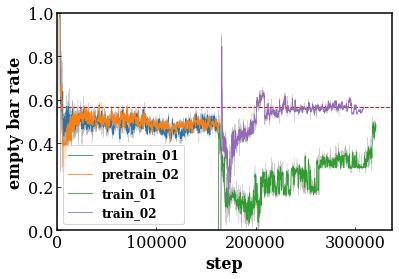

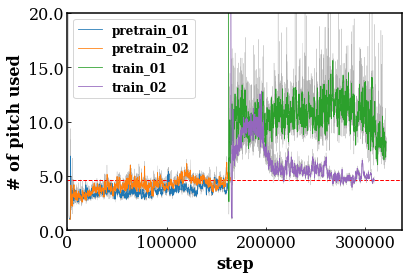

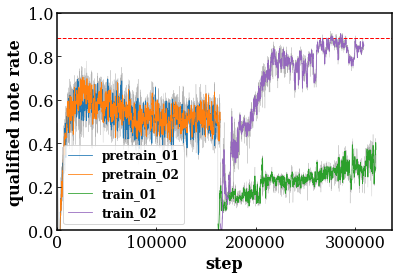

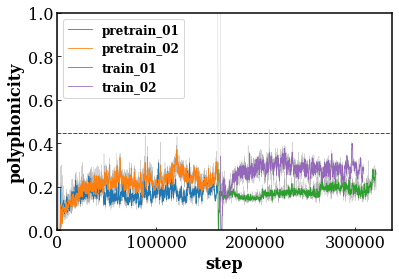

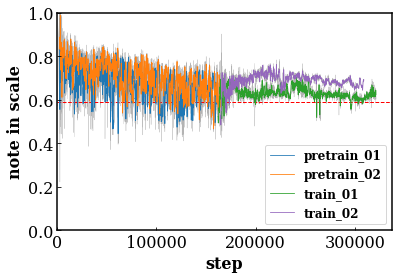

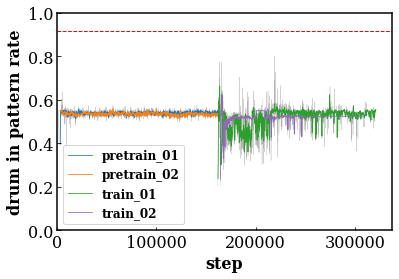

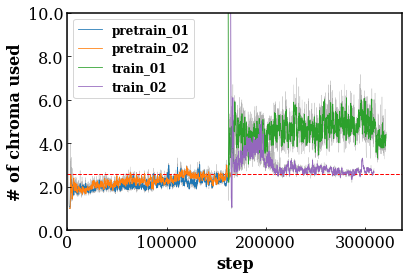

In [13]:
for m in range(7):
    plt.figure()
    plot_metrics(m, True)

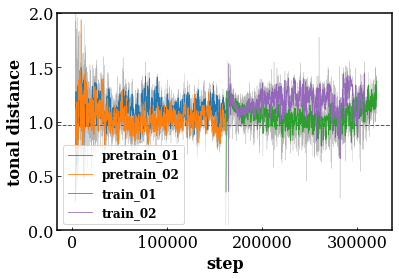

In [14]:
k = 5
h = (k - 1)//2
smooth = 'med' # 'avg', 'med', None

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.gca().set_prop_cycle('color', colors[:3] + colors[4:])

plot_tonal_distance(pretrained_01, m, smooth, k, label='pretrain_01',
                    linewidth=.8)
plot_tonal_distance(pretrained_02, m, smooth, k, label='pretrain_02',
                    linewidth=.8)
plot_tonal_distance(proposed_long, m, smooth, k, label='train_01',
                    linewidth=.8)
plot_tonal_distance(proposed_short, m, smooth, k, label='train_02',
                    linewidth=.8)

plt.axhline(y=train[()]['score_pair_matrix_mean'][0], color='tab:red',
            linestyle='--', linewidth=1.0, zorder=0)
plt.xlabel('step', fontweight='bold')
plt.ylabel('tonal distance', fontweight='bold')
plt.ylim(0, 2)
plt.legend(loc=3, prop={'size': 12, 'weight': 'bold'})
plt.setp(plt.gca().spines.values(), linewidth=1.5)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tick_params(direction='in')

filepath = os.path.join(result_dir, 'Vergleich_01_02',
                        'Vergleich_01_02_tonal_distance.' + extension)
plt.savefig(filepath, bbox_inches='tight')

--------------------- Vergleich 03/04 ----------------------

In [15]:
k = 5
h = (k - 1)//2
smooth = 'med' # 'avg', med', None

locs = [3, 2, 3, 2, 4, 3, 2]
ylims = [(0, 1), (0, 20), (0, 1), (0, 1), (0, 1), (0, 1), (0, 10)]

def plot_metrics(m, save=False, close=False):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.gca().set_prop_cycle('color', colors[:3] + colors[4:])

    plot_metric(pretrained_03, m, smooth, k, label='pretrain_03',
                linewidth=.8)
    plot_metric(pretrained_04, m, smooth, k, label='pretrain_04',
                linewidth=.8)
    plot_metric(proposed_03, m, smooth, k, label='train_03',
                linewidth=.8)
    plot_metric(proposed_04, m, smooth, k, label='train_04', linewidth=.8)

    plt.axhline(y=np.nanmean(train[()]['score_matrix_mean'][m, :]),
                color='r', linestyle='--', linewidth=1.0, zorder=0)
    plt.xlabel('step', fontweight='bold')
    plt.ylabel(metric_names[m], fontweight='bold')
    plt.gca().set_xlim(left=0)
    plt.ylim(ylims[m][0], ylims[m][1])
    plt.legend(loc=locs[m], prop={'size': 12, 'weight': 'bold'})
    plt.setp(plt.gca().spines.values(), linewidth=1.5)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.tick_params(direction='in')
    if save:
        filepath = os.path.join(result_dir, 'Vergleich_03_04',
                                'Vergleich_03_04{}.{}'.format(metric_file_names[m],
                                                         extension))
        plt.savefig(filepath, bbox_inches='tight')
    if close:
        plt.close()

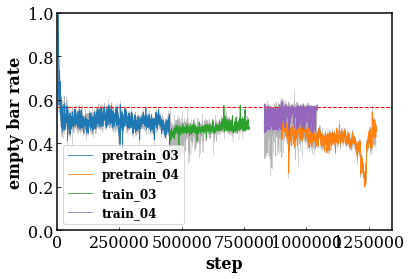

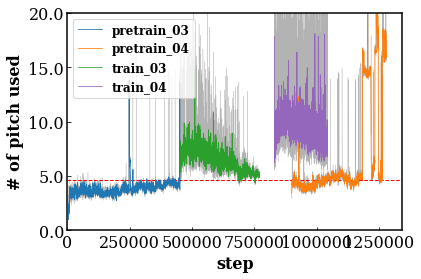

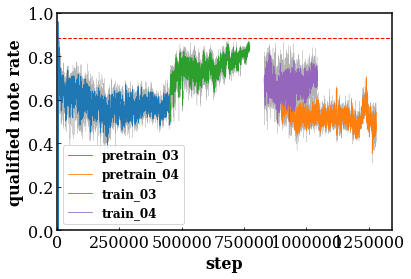

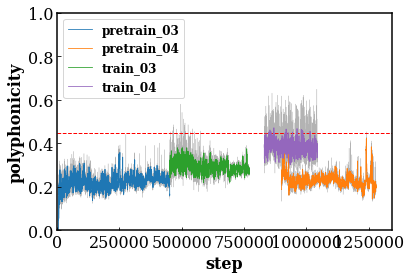

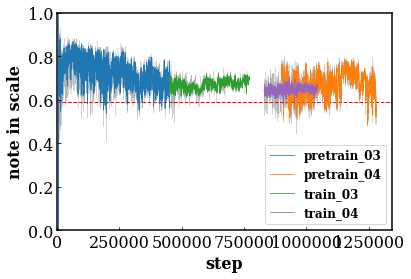

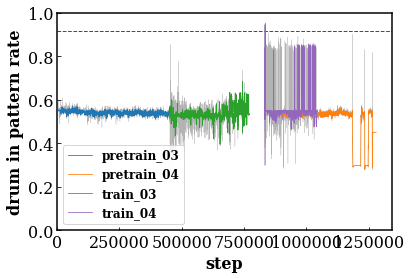

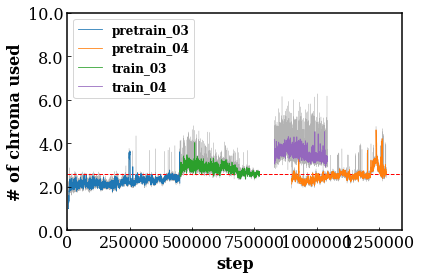

In [16]:
for m in range(7):
    plt.figure()
    plot_metrics(m, True)

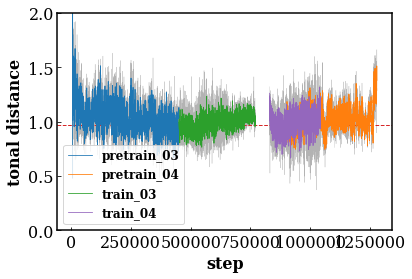

In [17]:
k = 5
h = (k - 1)//2
smooth = 'med' # 'avg', 'med', None

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.gca().set_prop_cycle('color', colors[:3] + colors[4:])

plot_tonal_distance(pretrained_03, m, smooth, k, label='pretrain_03',
                    linewidth=.8)
plot_tonal_distance(pretrained_04, m, smooth, k, label='pretrain_04',
                    linewidth=.8)
plot_tonal_distance(proposed_03, m, smooth, k, label='train_03',
                    linewidth=.8)
plot_tonal_distance(proposed_04, m, smooth, k, label='train_04',
                    linewidth=.8)

plt.axhline(y=train[()]['score_pair_matrix_mean'][0], color='tab:red',
            linestyle='--', linewidth=1.0, zorder=0)
plt.xlabel('step', fontweight='bold')
plt.ylabel('tonal distance', fontweight='bold')
plt.ylim(0, 2)
plt.legend(loc=3, prop={'size': 12, 'weight': 'bold'})
plt.setp(plt.gca().spines.values(), linewidth=1.5)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tick_params(direction='in')

filepath = os.path.join(result_dir, 'Vergleich_03_04',
                        'Vergleich_03_04_tonal_distance.' + extension)
plt.savefig(filepath, bbox_inches='tight')

# 02_b/02_r


In [18]:
k = 5
h = (k - 1)//2
smooth = 'med' # 'avg', med', None

locs = [3, 2, 3, 2, 4, 3, 2]
ylims = [(0, 1), (0, 20), (0, 1), (0, 1), (0, 1), (0, 1), (0, 10)]

def plot_metrics(m, save=False, close=False):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.gca().set_prop_cycle('color', colors[:3] + colors[4:])

    plot_metric(pretrained_02, m, smooth, k, label='pretrain_02',
                linewidth=.8)
    plot_metric(proposed_short, m, smooth, k, label='train_02b', linewidth=.8)
    plot_metric(proposed_short_r, m, smooth, k, label='train_02r', linewidth=.8)
    
    plt.axhline(y=np.nanmean(train[()]['score_matrix_mean'][m, :]),
                color='r', linestyle='--', linewidth=1.0, zorder=0)
    plt.xlabel('step', fontweight='bold')
    plt.ylabel(metric_names[m], fontweight='bold')
    plt.gca().set_xlim(left=0)
    plt.ylim(ylims[m][0], ylims[m][1])
    plt.legend(loc=locs[m], prop={'size': 12, 'weight': 'bold'})
    plt.setp(plt.gca().spines.values(), linewidth=1.5)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.tick_params(direction='in')
    if save:
        filepath = os.path.join(result_dir, 'Vergleich_02b_02r',
                                'Vergleich_02r_02b_{}.{}'.format(metric_file_names[m],
                                                         extension))
        plt.savefig(filepath, bbox_inches='tight')
    if close:
        plt.close()

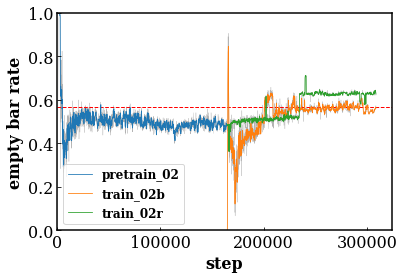

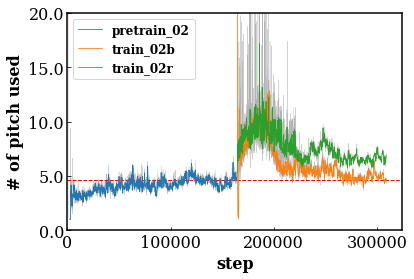

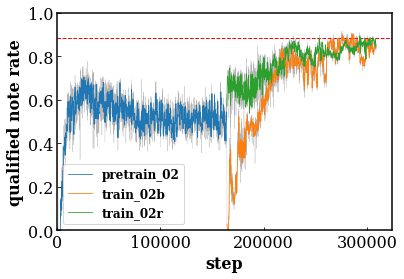

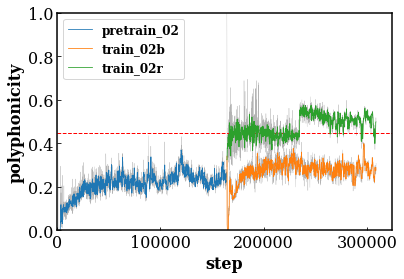

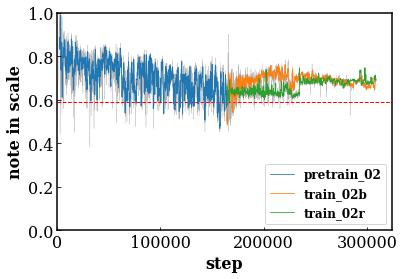

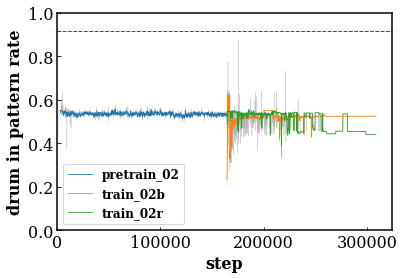

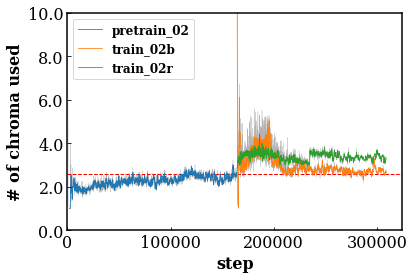

In [19]:
for m in range(7):
    plt.figure()
    plot_metrics(m, True)

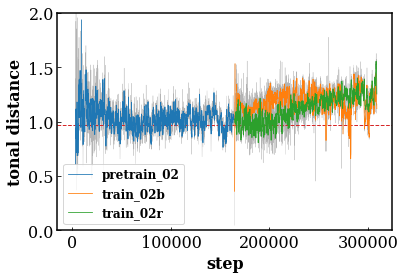

In [20]:
k = 5
h = (k - 1)//2
smooth = 'med' # 'avg', 'med', None

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.gca().set_prop_cycle('color', colors[:3] + colors[4:])

plot_tonal_distance(pretrained_02, m, smooth, k, label='pretrain_02',
                    linewidth=.8)
plot_tonal_distance(proposed_short, m, smooth, k, label='train_02b',
                    linewidth=.8)
plot_tonal_distance(proposed_short_r, m, smooth, k, label='train_02r',
                    linewidth=.8)

plt.axhline(y=train[()]['score_pair_matrix_mean'][0], color='tab:red',
            linestyle='--', linewidth=1.0, zorder=0)
plt.xlabel('step', fontweight='bold')
plt.ylabel('tonal distance', fontweight='bold')
plt.ylim(0, 2)
plt.legend(loc=3, prop={'size': 12, 'weight': 'bold'})
plt.setp(plt.gca().spines.values(), linewidth=1.5)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tick_params(direction='in')

filepath = os.path.join(result_dir, 'Vergleich_02b_02r',
                        'Vergleich_02r_02b_tonal_distance.' + extension)
plt.savefig(filepath, bbox_inches='tight')

# 1/2r/2b

In [21]:
k = 5
h = (k - 1)//2
smooth = 'med' # 'avg', med', None

locs = [3, 2, 3, 2, 4, 3, 2]
ylims = [(0, 1), (0, 20), (0, 1), (0, 1), (0, 1), (0, 1), (0, 10)]

def plot_metrics(m, save=False, close=False):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.gca().set_prop_cycle('color', colors[:3] + colors[4:])

    #plot_metric(pretrained_03, m, smooth, k, label='pretrain_03',
                #linewidth=.8)
    plot_metric(pretrained_02, m, smooth, k, label='pretrain_02b',
                linewidth=.8)
    plot_metric(proposed_03, m, smooth, k, label='train_03',
                linewidth=.8)
    plot_metric(proposed_short, m, smooth, k, label='train_02', linewidth=.8)
    plot_metric(proposed_short_r, m, smooth, k, label='train_02r', linewidth=.8)
    
    plt.axhline(y=np.nanmean(train[()]['score_matrix_mean'][m, :]),
                color='r', linestyle='--', linewidth=1.0, zorder=0)
    plt.xlabel('step', fontweight='bold')
    plt.ylabel(metric_names[m], fontweight='bold')
    plt.gca().set_xlim(left=0)
    plt.ylim(ylims[m][0], ylims[m][1])
    plt.legend(loc=locs[m], prop={'size': 12, 'weight': 'bold'})
    plt.setp(plt.gca().spines.values(), linewidth=1.5)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.tick_params(direction='in')
    if save:
        filepath = os.path.join(result_dir, 'Vergleich_03_02br',
                                'Vergleich_01_02_{}.{}'.format(metric_file_names[m],
                                                         extension))
        plt.savefig(filepath, bbox_inches='tight')
    if close:
        plt.close()

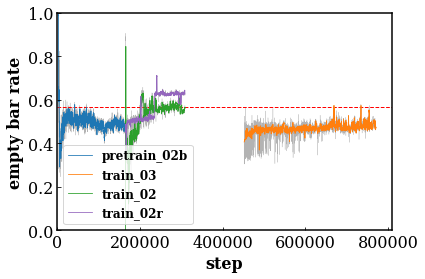

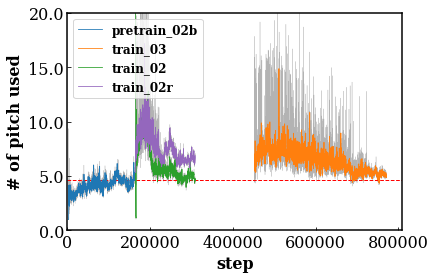

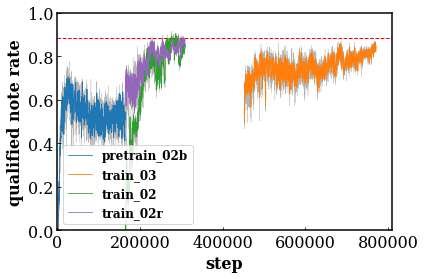

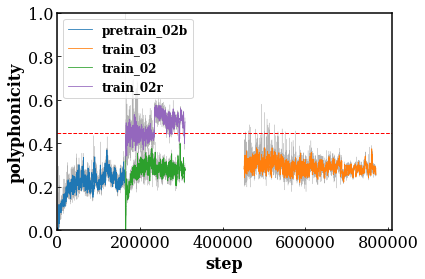

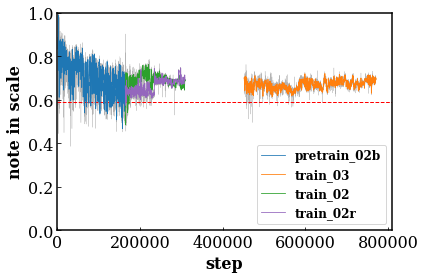

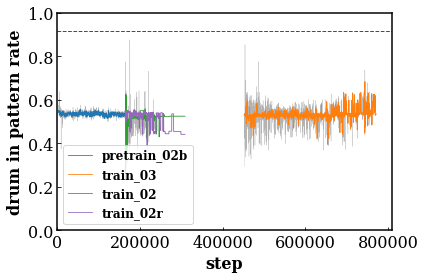

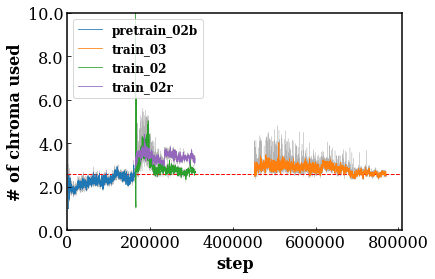

In [22]:
for m in range(7):
    plt.figure()
    plot_metrics(m, True)

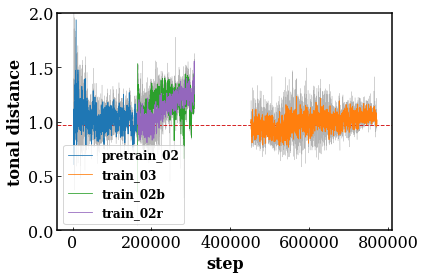

In [23]:
k = 5
h = (k - 1)//2
smooth = 'med' # 'avg', 'med', None

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.gca().set_prop_cycle('color', colors[:3] + colors[4:])

#plot_tonal_distance(pretrained_03, m, smooth, k, label='pretrain_03',
                    #linewidth=.8)
plot_tonal_distance(pretrained_02, m, smooth, k, label='pretrain_02',
                    linewidth=.8)
plot_tonal_distance(proposed_03, m, smooth, k, label='train_03',
                    linewidth=.8)
plot_tonal_distance(proposed_short, m, smooth, k, label='train_02b',
                    linewidth=.8)
plot_tonal_distance(proposed_short_r, m, smooth, k, label='train_02r',
                    linewidth=.8)

plt.axhline(y=train[()]['score_pair_matrix_mean'][0], color='tab:red',
            linestyle='--', linewidth=1.0, zorder=0)
plt.xlabel('step', fontweight='bold')
plt.ylabel('tonal distance', fontweight='bold')
plt.ylim(0, 2)
plt.legend(loc=3, prop={'size': 12, 'weight': 'bold'})
plt.setp(plt.gca().spines.values(), linewidth=1.5)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tick_params(direction='in')

filepath = os.path.join(result_dir, 'Vergleich_03_02br',
                        'Vergleich_01_02_tonal_distance.' + extension)
plt.savefig(filepath, bbox_inches='tight')

# Vergleich 02Old 02New

In [14]:
k = 5
h = (k - 1)//2
smooth = 'med' # 'avg', med', None

locs = [3, 2, 3, 2, 4, 3, 2]
ylims = [(0, 1), (0, 20), (0, 1), (0, 1), (0, 1), (0, 1), (0, 10)]

def plot_metrics(m, save=False, close=False):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.gca().set_prop_cycle('color', colors[:3] + colors[4:])

    plot_metric(pretrained_02N, m, smooth, k, label='pretrain_02N',
                linewidth=.8)
    plot_metric(pretrained_02, m, smooth, k, label='pretrain_02',
                linewidth=.8)

    plot_metric(proposed_short, m, smooth, k, label='train_02', linewidth=.8)
    plot_metric(proposed_short_r, m, smooth, k, label='train_02r', linewidth=.8)
    plot_metric(proposed_shortN, m, smooth, k, label='train_02N', linewidth=.8)
    plot_metric(proposed_short_rN, m, smooth, k, label='train_02rN', linewidth=.8)
    
    plt.axhline(y=np.nanmean(train[()]['score_matrix_mean'][m, :]),
                color='r', linestyle='--', linewidth=1.0, zorder=0)
    plt.xlabel('step', fontweight='bold')
    plt.ylabel(metric_names[m], fontweight='bold')
    plt.gca().set_xlim(left=0)
    plt.ylim(ylims[m][0], ylims[m][1])
    plt.legend(loc=locs[m], prop={'size': 12, 'weight': 'bold'})
    plt.setp(plt.gca().spines.values(), linewidth=1.5)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.tick_params(direction='in')
    if save:
        filepath = os.path.join(result_dir, 'Vergleich_2old_2new',
                                'Vergleich_2old_2new_{}.{}'.format(metric_file_names[m],
                                                         extension))
        plt.savefig(filepath, bbox_inches='tight')
    if close:
        plt.close()

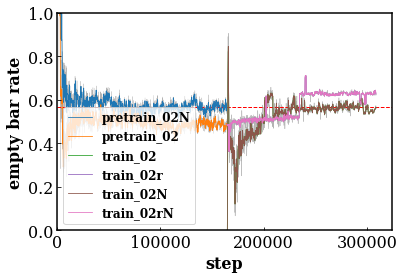

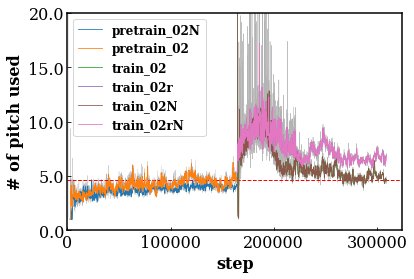

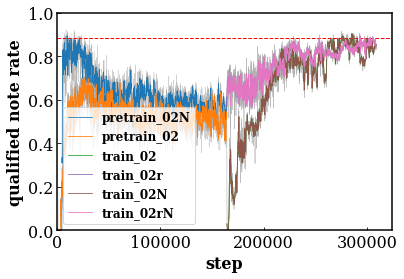

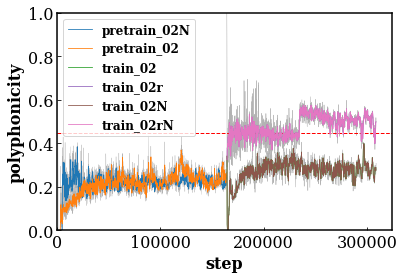

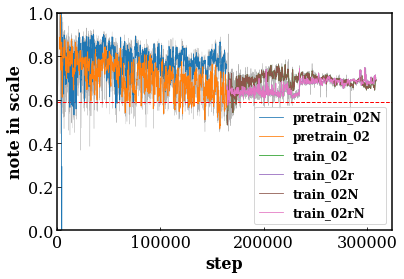

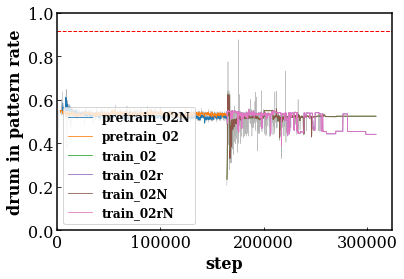

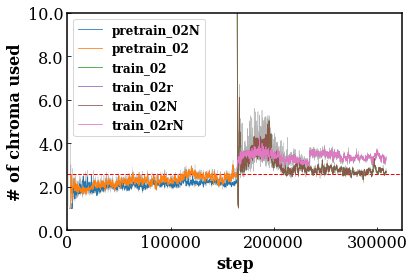

In [15]:
for m in range(7):
    plt.figure()
    plot_metrics(m, True)

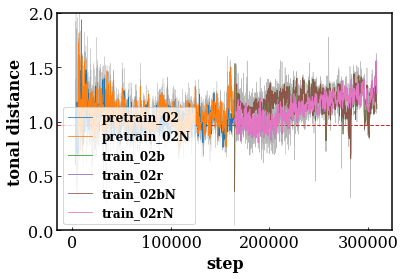

In [16]:
k = 5
h = (k - 1)//2
smooth = 'med' # 'avg', 'med', None

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.gca().set_prop_cycle('color', colors[:3] + colors[4:])

#plot_tonal_distance(pretrained_03, m, smooth, k, label='pretrain_03',
                    #linewidth=.8)
plot_tonal_distance(pretrained_02, m, smooth, k, label='pretrain_02',
                    linewidth=.8)
plot_tonal_distance(pretrained_02N, m, smooth, k, label='pretrain_02N',
                    linewidth=.8)
plot_tonal_distance(proposed_short, m, smooth, k, label='train_02b',
                    linewidth=.8)
plot_tonal_distance(proposed_short_r, m, smooth, k, label='train_02r',
                    linewidth=.8)
plot_tonal_distance(proposed_shortN, m, smooth, k, label='train_02bN',
                    linewidth=.8)
plot_tonal_distance(proposed_short_rN, m, smooth, k, label='train_02rN',
                    linewidth=.8)
plt.axhline(y=train[()]['score_pair_matrix_mean'][0], color='tab:red',
            linestyle='--', linewidth=1.0, zorder=0)
plt.xlabel('step', fontweight='bold')
plt.ylabel('tonal distance', fontweight='bold')
plt.ylim(0, 2)
plt.legend(loc=3, prop={'size': 12, 'weight': 'bold'})
plt.setp(plt.gca().spines.values(), linewidth=1.5)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tick_params(direction='in')

filepath = os.path.join(result_dir, 'Vergleich_2old_2new',
                        'Vergleich_2old_2new_tonal_distance.' + extension)
plt.savefig(filepath, bbox_inches='tight')